In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,69.5,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.5,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.5,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.4,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.5,69.400000,66.666466,0.0,0,0


In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()
testing_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-03-20 00:00:00+00:00,72.8,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,73.0,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,73.0,67.891817,0.0,0,0


In [5]:
train_y = training_data['t_next']
train_X = training_data.drop(['t_next'], axis=1)
train_X.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-04-18 23:16:42+00:00,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.400000,66.666466,0.0,0,0


In [6]:
test_y = testing_data['t_next']
test_X = testing_data.drop(['t_next'], axis=1)
test_X.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,67.891817,0.0,0,0


In [7]:
from sklearn import linear_model

lasso_clf = linear_model.Lasso(alpha=0.1)
lasso_clf.fit(train_X, train_y)
test_pred = lasso_clf.predict(test_X)

In [8]:
rmse = sqrt(mean_squared_error(test_y,test_pred))
rmse

0.8593494185379873

In [11]:
def forecasting(test_X, test_y, start_time, duration, linearModel):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in test_X.index:
            #print("Not present")
            return None
        input_x = test_X.loc[curr_time].copy()
        if predictions_i:
            input_x['t_in'] = predictions_i[-1]
        y = linearModel.predict([input_x])
        predictions_i.append(y[0])
        errs_i.append(test_y.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [12]:
predictions = []
errs = []
startSamples = test_X.sample(n=800)
startList = startSamples.index
duration = 60 * 7
for start in startList:
    errs_i = forecasting(test_X, test_y, start, duration, lasso_clf)
    #predictions.append(pd.Series(index=range(len(predictions_i)), data=predictions_i))
    if errs_i:
        errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
#print(predictions)
#print(errs)

[0.18113304969041327, 0.3317280221529557, 0.39092355460459616, 0.45943924879286024, 0.5147979057030185, 0.5866190833695764, 0.6680606786640518, 0.7269700202272447, 0.7727913506866575, 0.8122833569519202, 0.8500785962430973, 0.9118878167652984, 0.9593970123498257, 1.0163383632988605, 1.0738338279828286, 1.109784979149596, 1.1395427892326793, 1.1758125015483298, 1.2028117725472378, 1.2264817661958627, 1.2672053366803764, 1.3058783871829553, 1.3492987653525894, 1.4008596685193102, 1.4289819577959293, 1.4758700626058903, 1.5042051373940952, 1.544726516578703, 1.5908072541549059, 1.6266255937625926, 1.6375976960947018, 1.655272343519627, 1.6781314892590125, 1.7056434352325545, 1.7371409779560312, 1.7799791800648477, 1.8249070850988298, 1.8440671890880844, 1.8633990335377253, 1.8914264039976094, 1.916460686740766, 1.9352505868771008, 1.9544720761537064, 1.97577276544617, 2.0001379512505735, 2.0178774665034167, 2.0478168389349376, 2.0912362951274224, 2.1076837662776797, 2.116520529608171, 2.1

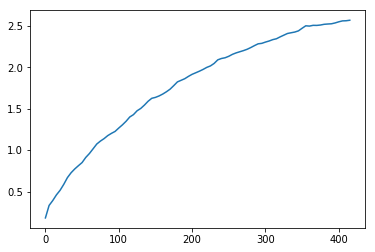

In [13]:
final_errors = []
for i in range(int(duration/5)):
    ei = np.array([])
    for e in errs:
        ei = np.append(ei, e.loc[i]*e.loc[i])
    final_errors.append(sqrt(np.mean(ei)))
#final_errors = pd.Series(index=range(len(final_errors)), data = final_errors)
print(final_errors)
timesteps = [x*5 for x in range(len(final_errors))]
plt.plot(timesteps,final_errors)
plt.show()